## Background

In this notebook, I'll fine-tune different TinyStories base models on the `financial_phrasebank` dataset to perform sentiment classification on financial news text. In a [previous blog post](https://vishalbakshi.github.io/blog/posts/2024-08-05-tinyinstruct-sentiment-classification/) I showed that TinyStories-Instruct-33M does not follow even simple instructions (e.g., _"What is the color an apple?"_) that deviate from its training data, so that motivated me to finetune these models.

The [TinyStories paper](https://arxiv.org/abs/2305.07759) doesn't include any hyperparameters (of particular interest are the learning rate and batch size) used to train their models so I'll experiment with different values.

In [1]:
#| code-fold: true
#| code-summary: "Show imports and setup"

#!pip install accelerate evaluate datasets -Uqq
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, TrainerCallback
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()
    
model_nm = "roneneldan/TinyStories-33M"
#model_nm = "roneneldan/TinyStories-1M"
#model_nm = "roneneldan/TinyStories-3M"
#model_nm = "roneneldan/TinyStories-8M"

tokz = AutoTokenizer.from_pretrained(model_nm)
def tok_func(x): return tokz(x["input"], padding=True, truncation=True)

2024-08-14 01:38:25.564071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 01:38:25.564133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 01:38:25.565856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#| code-fold: true
#| code-summary: "Show load_dataset"

dataset = load_dataset(
    "financial_phrasebank", "sentences_allagree",
    split="train"  # note that the dataset does not have a default test split
)

# # Source: https://huggingface.co/blog/synthetic-data-save-costs
# # create a new column with the numeric label verbalised as label_text (e.g. "positive" instead of "0")
# label_map = {
#     i: label_text
#     for i, label_text in enumerate(dataset.features["label"].names)
# }

# def add_label_text(example):
#     example["labels"] = label_map[example["label"]]
#     return example

# dataset = dataset.map(add_label_text)

## Initial Fine-Tune

### Tokenize the Dataset

The HuggingFace Trainer, if I'm not mistaken, expects the target variable to have the title `labels` and the independent variable titled `input` for classification tasks:

In [3]:
dataset = dataset.rename_columns({'label':'labels', 'sentence': 'input'})

In [4]:
tokz.add_special_tokens({'pad_token': '[PAD]'})
tokz.padding_side = "left" # https://github.com/huggingface/transformers/issues/16595 and https://www.kaggle.com/code/baekseungyun/gpt-2-with-huggingface-pytorch

In [5]:
tok_ds = dataset.map(tok_func, batched=True)
tok_ds

Dataset({
    features: ['input', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 2264
})

In [6]:
tok_ds[0]['input']

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

In [7]:
tok_ds[0]['input_ids'][100:110] # first 100 elements are 50257 ('[PAD]')

[50257, 50257, 50257, 50257, 50257, 50257, 4821, 284, 17113, 837]

In [8]:
tokz.decode(50257), tokz.decode(4821), tokz.decode(284), tokz.decode(17113)

('[PAD]', 'According', ' to', ' Gran')

In [9]:
tok_ds[0]['labels']

1

### Train-Valid-Test Split

The `financial_phrasebank` dataset doesn't have a default test split, so I'll use 225 sentences (~10%) as the test set. I'll split the remaining data into an 80/20 train/validation set.

In [10]:
split_dataset = tok_ds.train_test_split(test_size=225/2264, seed=42)

training_split = split_dataset['train'].train_test_split(test_size=0.2, seed=42)

train_ds = training_split['train']
eval_ds = training_split['test']
test_ds = split_dataset['test']

train_ds, eval_ds, test_ds

(Dataset({
     features: ['input', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 1631
 }),
 Dataset({
     features: ['input', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 408
 }),
 Dataset({
     features: ['input', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 225
 }))

In [11]:
train_ds[0]['input']

'The result will also be burdened by increased fixed costs associated with operations in China , and restructuring costs in Japan .'

In [12]:
train_ds[0]['labels']

0

Looking at the distribution of `label` values (negative, positive, neutral) in each dataset, they contain roughly the same split:

In [13]:
train_ds.to_pandas()['labels'].value_counts() / len(train_ds)

labels
1    0.622318
2    0.251993
0    0.125690
Name: count, dtype: float64

In [14]:
eval_ds.to_pandas()['labels'].value_counts() / len(eval_ds)

labels
1    0.615196
2    0.257353
0    0.127451
Name: count, dtype: float64

In [15]:
test_ds.to_pandas()['labels'].value_counts() / len(test_ds)

labels
1    0.555556
2    0.240000
0    0.204444
Name: count, dtype: float64

### Initial Training Run

I'll define some initial hyperparameters, re-using most of what was used in Part 1 of the fastai course in Jeremy's ["Getting started with NLP for absolute beginners" notebook](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners#Test-and-validation-sets).

In [24]:
lr = 8e-5
epochs = 3
bs = 16

I'll use accuracy as my metric:

In [13]:
def get_acc(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": (predictions == labels).astype(np.float32).mean().item()}

I'll also try to implement a callback (to capture the metrics later on when I'm doing hyperparameter sweeps).

In [14]:
#| code-fold: true
#| code-summary: "Show MetricCallback code"

# thanks Claude

class MetricCallback(TrainerCallback):
    def __init__(self):
        self.metrics = []
        self.current_epoch_metrics = {}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.current_epoch_metrics.update(logs)

    def on_epoch_end(self, args, state, control, **kwargs):
        if hasattr(state, 'log_history') and state.log_history:
            # Get the last logged learning rate
            last_lr = state.log_history[-1].get('learning_rate', None)
        else:
            last_lr = None

        self.metrics.append({
            "epoch": state.epoch,
            "learning_rate": last_lr,
            **self.current_epoch_metrics
        })
        self.current_epoch_metrics = {}  # Reset for next epoch

    def on_train_end(self, args, state, control, **kwargs):
        # Capture final metrics after the last epoch
        if self.current_epoch_metrics:
            self.metrics.append({
                "epoch": state.num_train_epochs,
                "learning_rate": self.metrics[-1].get('learning_rate') if self.metrics else None,
                **self.current_epoch_metrics
            })

In [61]:
metric_callback = MetricCallback()

In [62]:
args = TrainingArguments(
    'outputs',
    learning_rate=lr,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    fp16=True,
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs,
    weight_decay=0.01,
    report_to='none')

In [63]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=3) # 3 labels for 3 classes
trainer = Trainer(model, args, train_dataset=train_ds, eval_dataset=eval_ds, 
                  tokenizer=tokz, compute_metrics=get_acc, callbacks=[metric_callback])

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at roneneldan/TinyStories-33M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
model.resize_token_embeddings(len(tokz)) # do this otherwise I get a "index out of range" error

Embedding(50258, 768)

In [65]:
model.config.pad_token_id = model.config.eos_token_id # do this otherwise I get an error about padding tokens

In [66]:
trainer.train();

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.809300,0.450100,0.833333
2,0.192700,0.429838,0.889706
3,0.010500,0.751890,0.879902


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


The `metric_callback` stores the loss, accuracy and runtime (among other metrics) for each epoch:

In [67]:
results = []
results.append({"learning_rate": lr, "metrics": metric_callback.metrics})

In [15]:
#| code-fold: true
#| code-summary: "Show function to convert results dict into DataFrame"

def results_to_dataframe(results, model_name):
    rows = []
    for result in results:
        initial_lr = result['learning_rate']
        for metric in result['metrics']:
            row = {
                'model_name': model_name,
                'initial_learning_rate': initial_lr,
                'current_learning_rate': metric.get('learning_rate'),
            }
            row.update(metric)
            rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Ensure specific columns are at the beginning
    first_columns = ['model_name', 'initial_learning_rate', 'current_learning_rate', 'epoch']
    other_columns = [col for col in df.columns if col not in first_columns]
    df = df[first_columns + other_columns]
    
    return df

In [109]:
res_df = results_to_dataframe(results, model_name="TinyStories-33M")
res_df

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,TinyStories-33M,0.00008,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TinyStories-33M,0.00008,0.000068,1.0,0.000068,0.8093,9.747781e+05,0.450100,0.833333,0.8285,492.428,8.449,NaN,NaN,NaN,NaN,NaN
2,TinyStories-33M,0.00008,0.000024,2.0,0.000024,0.1927,1.633982e+06,0.429838,0.889706,0.8315,490.653,8.418,NaN,NaN,NaN,NaN,NaN
3,TinyStories-33M,0.00008,0.000000,3.0,0.000000,0.0105,2.495563e+04,0.751890,0.879902,0.9311,438.202,7.518,35.2349,138.868,4.342,1.090163e+14,0.337512


### Evaluating Model Performance on the Test Set

I'll see how well the model does on the 10% test set that I've set aside.

In [72]:
test_df = test_ds.to_pandas()[['input', 'labels']]
test_df.head()

,input,labels
0,"Indigo and Somoncom serve 377,000 subscribers ...",1
1,The sellers were EOSS Innovationsmanagement an...,1
2,UPM-Kymmene said its has ` not indicated any i...,1
3,These financing arrangements will enable the c...,2
4,Fortum expects its annual capital expenditure ...,1


In [73]:
preds = trainer.predict(test_ds).predictions.astype(float)
probs = F.softmax(torch.tensor(preds), dim=1)
predicted_classes = torch.argmax(probs, dim=1).numpy()

test_df['predicted'] = predicted_classes
test_df.head()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


,input,labels,predicted
0,"Indigo and Somoncom serve 377,000 subscribers ...",1,1
1,The sellers were EOSS Innovationsmanagement an...,1,1
2,UPM-Kymmene said its has ` not indicated any i...,1,1
3,These financing arrangements will enable the c...,2,1
4,Fortum expects its annual capital expenditure ...,1,1


This training run resulted in a TinyStories-33M finetuned model that predicted 85% of the 225 test sentences' sentiment correctly.

In [76]:
test_df['match'] = test_df['labels'] == test_df['predicted']
test_df['match'].mean()

0.8488888888888889

I'll reuse a confusion matrix helper function I created in a previous notebook:

In [104]:
label_map = {i: label_text for i, label_text in enumerate(test_ds.features["labels"].names)}
label_map

{0: 'negative', 1: 'neutral', 2: 'positive'}

In [86]:
test_df['label_text'] = test_df['labels'].apply(lambda x: label_map[x])
test_df['pred_text'] = test_df['predicted'].apply(lambda x: label_map[x])

In [16]:
#| code-fold: true
#| code-summary: "Show function to make confusion matrix"

def make_cm(df):
    """Create confusion matrix for true vs predicted sentiment classes"""
    
    cm = confusion_matrix(y_true=df['label_text'], y_pred=df['pred_text'], labels=['negative', 'neutral', 'positive'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'neutral', 'positive'])
    
    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax,text_kw={'fontsize': 12}, cmap='Blues', colorbar=False);
    
    # change label font size without changing label text
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    
    # make tick labels larger
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

The model predicted `neutral` sentences with the highest accuracy (122/125), followed by `negative` sentences (32/46) and finally `positive` sentences (37/54).

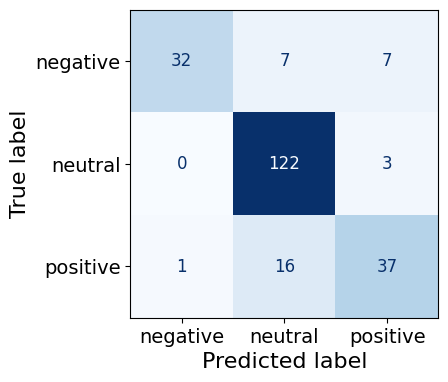

In [94]:
make_cm(test_df)

As a final sanity check, I'll prompt the model with a made-up financial new sentence and see if it correctly classifies it (as positive, negative, or neutral):

In [17]:
#| code-fold: true
#| code-summary: "Show function to generate a prediction"

def get_prediction(model, text, tokz):
    # Determine the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move the model to the appropriate device
    model = model.to(device)

    # Tokenize the input text
    inputs = tokz(text, return_tensors="pt", truncation=True, padding=True)

    # Move input tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get the model's prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(**inputs)

    # Ensure logits are on CPU for numpy operations
    logits = outputs.logits.detach().cpu()

    # Get probabilities
    probs = torch.softmax(logits, dim=-1)

    # Get the predicted class
    p_class = torch.argmax(probs, dim=-1).item()

    # Get the probability for the predicted class
    p = probs[0][p_class].item()

    labels = {0: "negative", 1: "neutral", 2: "positive"}
    
    print(f"Probability: {p:.2f}")
    print(f"Predicted label: {labels[p_class]}")
    return p_class, p

In [101]:
text = "The net sales went up from USD $3.4M to USD $5.6M since the same quarter last year"

_ = get_prediction(model, text, tokz)

Probability: 0.60
Predicted label: positive


In [102]:
text = "The net sales went down from USD $8.9M to USD $1.2M since the same quarter last year"

_ = get_prediction(model, text, tokz)

Probability: 1.00
Predicted label: negative


In [103]:
text = "The net sales stayed the as the same quarter last year"

_ = get_prediction(model, text, tokz)

Probability: 0.93
Predicted label: neutral


## Learning Rate Sweep

Let's see if I can beat the validation accuracy of 89% and test set accuracy of 85% by using different learning rates. I'll wrap up some of the training code (there's so much of it!!) in helper functions so I can loop through my learning rates. I've also created a helper function to get the test set accuracy.

In [18]:
#| code-fold: true
#| code-summary: "Show function to prep trainer"

def get_trainer(lr, bs=16):

    args = TrainingArguments(
        'outputs',
        learning_rate=lr,
        warmup_ratio=0.1,
        lr_scheduler_type='cosine',
        fp16=True,
        eval_strategy="epoch",
        logging_strategy="epoch",
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs*2,
        num_train_epochs=3,
        weight_decay=0.01,
        report_to='none')
    
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=3) # 3 labels for 3 classes
    model.resize_token_embeddings(len(tokz))
    model.config.pad_token_id = model.config.eos_token_id
    
    trainer = Trainer(model, args, train_dataset=train_ds, eval_dataset=eval_ds, 
                  tokenizer=tokz, compute_metrics=get_acc, callbacks=[metric_callback])
    
    return trainer, args

In [19]:
#| code-fold: true
#| code-summary: "Show function to get test set accuracy"

def get_test_df(trainer):
    test_df = test_ds.to_pandas()[['input', 'labels']]
    
    preds = trainer.predict(test_ds).predictions.astype(float)
    probs = F.softmax(torch.tensor(preds), dim=1)
    predicted_classes = torch.argmax(probs, dim=1).numpy()

    test_df['predicted'] = predicted_classes
    
    test_df['match'] = test_df['labels'] == test_df['predicted']
    acc = test_df['match'].mean()
    
    label_map = {i: label_text for i, label_text in enumerate(test_ds.features["labels"].names)}
    test_df['label_text'] = test_df['labels'].apply(lambda x: label_map[x])
    test_df['pred_text'] = test_df['predicted'].apply(lambda x: label_map[x])
    
    return test_df, acc

In [ ]:
#| code-fold: true
#| code-summary: "Show training loop"

metrics = []
trainers = []
learning_rates = [1e-6, 1e-5, 3e-5, 5e-5, 8e-5, 1e-4, 3e-4, 5e-4, 8e-4, 1e-3, 1e-2, 1e-1]
#learning_rates = [8e-5]

for lr in learning_rates:
    print(f"Learning Rate: {lr}")
    
    metric_callback = MetricCallback()
    
    trainer, args = get_trainer(lr, bs=64)

    trainer.train()

    metrics.append({
        "learning_rate": lr,
        "metrics": metric_callback.metrics
        })
    
    trainers.append(trainer) 
    
    # clean up
    report_gpu()
    report_gpu()
    !rm -r /kaggle/working/outputs

In [50]:
metrics_df = results_to_dataframe(metrics, model_name="TinyStories-33M")
metrics_df = metrics_df.query('current_learning_rate.notna()')

In [51]:
metrics_df.head()

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
1,TinyStories-33M,0.000001,8.455313e-07,1.0,8.455313e-07,1.0189,1631760.000,0.955949,0.588235,0.7160,569.866,2.793,NaN,NaN,NaN,NaN,NaN
2,TinyStories-33M,0.000001,3.034875e-07,2.0,3.034875e-07,0.8713,1828322.000,0.902843,0.612745,0.7188,567.645,2.783,NaN,NaN,NaN,NaN,NaN
3,TinyStories-33M,0.000001,0.000000e+00,3.0,0.000000e+00,0.8171,1519178.375,0.894423,0.620098,0.7479,545.515,2.674,25.9696,188.413,1.502,1.090163e+14,0.902434
5,TinyStories-33M,0.000010,8.455313e-06,1.0,8.455313e-06,1.2371,1272109.750,0.816271,0.617647,0.7218,565.288,2.771,NaN,NaN,NaN,NaN,NaN
6,TinyStories-33M,0.000010,3.034875e-06,2.0,3.034875e-06,0.5578,1321395.500,0.704009,0.713235,0.7366,553.892,2.715,NaN,NaN,NaN,NaN,NaN


### Learning Rate with Highest Validation Accuracy

The learning rate with the highest validation set accuracy (85.5%) is `0.0005` (5e-4).

In [52]:
metrics_df.query('eval_accuracy == eval_accuracy.max()')

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
31,TinyStories-33M,0.0005,0.0,3.0,0.0,0.2443,389968.15625,0.406566,0.855392,0.7971,511.863,2.509,25.9521,188.54,1.503,1.090163e+14,0.819404


In [54]:
learning_rates[7]

0.0005

The corresponding model has a 79% accuracy on the test set.

In [55]:
test_df, acc = get_test_df(trainers[7])
acc

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


0.7911111111111111

Similar to before the model does well at predicting `neutral` sentences (119/125). This time, the model has a better accuracy with `positive` sentences (41/54) than `negative` sentences where it gets less than 50% correct (18/46).

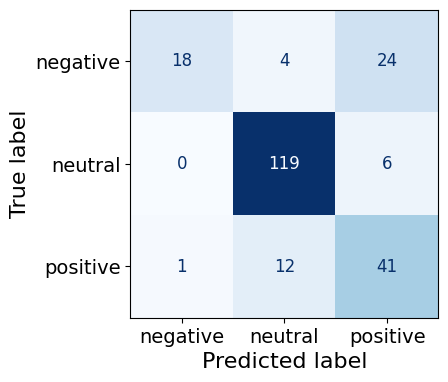

In [56]:
make_cm(test_df)

Interestingly enough, this model gets my made-up "positive" sentence incorrect (while getting the "neutral" and "negative" made-up ones correct):

In [57]:
text = "The net sales went up from USD $3.4M to USD $5.6M since the same quarter last year"

_ = get_prediction(trainers[7].model, text, tokz)

Probability: 0.49
Predicted label: neutral


In [58]:
text = "The net sales went down from USD $8.9M to USD $1.2M since the same quarter last year"

_ = get_prediction(trainers[7].model, text, tokz)

Probability: 0.36
Predicted label: negative


In [59]:
text = "The net sales stayed the as the same quarter last year"

_ = get_prediction(trainers[7].model, text, tokz)

Probability: 0.54
Predicted label: neutral


#### Relationship between Learning Rate and Validation Accuracy

The validation set accuracy starts low, increases to a peak at `lr=0.0005` and then decreases again. I've used a log-scale on the x-axis to more easily view all of the data.

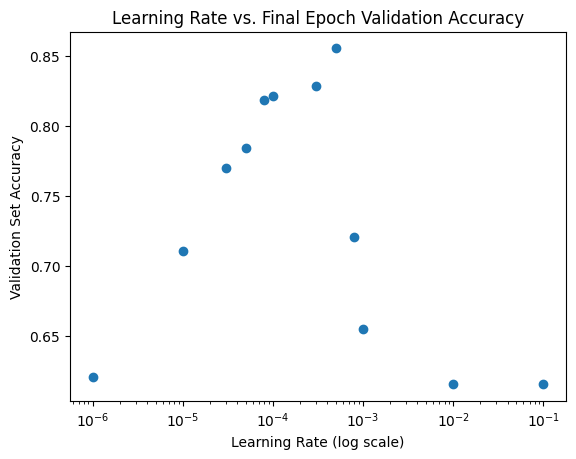

In [72]:
final_epoch_metrics = metrics_df.query("epoch == 3")
plt.scatter(final_epoch_metrics['initial_learning_rate'], final_epoch_metrics['eval_accuracy']);
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation Set Accuracy')
plt.title('Learning Rate vs. Final Epoch Validation Accuracy');

### Learning Rate with Highest Test Set Accuracy

In [ ]:
test_dfs = []
accs = []
for t in trainers:
    test_df, acc = get_test_df(t)
    test_dfs.append(test_df)
    accs.append(acc)

The learning rate of 0.0005 also had the highest test set accuracy.

In [75]:
accs

[0.6088888888888889,
 0.6222222222222222,
 0.7066666666666667,
 0.7155555555555555,
 0.72,
 0.7511111111111111,
 0.76,
 0.7911111111111111,
 0.6622222222222223,
 0.6177777777777778,
 0.5555555555555556,
 0.5555555555555556]

## Training with the Best Learning Rate 10 Times

I'm curious how consistently this model trains so I'll train it 10 times with the best-performing learning rate.

In [ ]:
best_metrics = []
best_trainers = []
lr = 0.0005

for i in range(10):
    
    metric_callback = MetricCallback()
    trainer, args = get_trainer(lr=lr, bs=64)
    trainer.train()

    best_metrics.append({
        "learning_rate": lr,
        "metrics": metric_callback.metrics
        })
    
    best_trainers.append(trainer) 
    
    # clean up
    report_gpu()
    report_gpu()
    !rm -r /kaggle/working/outputs

In [23]:
best_metrics_df = results_to_dataframe(best_metrics, model_name="TinyStories-33M")
best_metrics_df = best_metrics_df.query('current_learning_rate.notna()')
best_metrics_df.head(3)

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
1,TinyStories-33M,0.0005,0.000423,1.0,0.000423,2.0251,2.925652e+05,0.693838,0.723039,0.7110,573.874,2.813,NaN,NaN,NaN,NaN,NaN
2,TinyStories-33M,0.0005,0.000152,2.0,0.000152,0.6226,1.006726e+06,0.634036,0.678922,0.7205,566.265,2.776,NaN,NaN,NaN,NaN,NaN
3,TinyStories-33M,0.0005,0.000000,3.0,0.000000,0.3786,2.750663e+05,0.581288,0.769608,0.7977,511.497,2.507,26.0778,187.631,1.496,1.090163e+14,1.008766


I would say this model's training is quite consistent! Almost too consistent? Something feels weird about it getting the same accuracy for 9 out of the 10 runs.

In [24]:
final_accs = best_metrics_df.query("epoch == 3")['eval_accuracy']
final_accs.describe()

count    10.000000
mean      0.846814
std       0.027127
min       0.769608
25%       0.855392
50%       0.855392
75%       0.855392
max       0.855392
Name: eval_accuracy, dtype: float64

In [25]:
final_accs.value_counts()

eval_accuracy
0.855392    9
0.769608    1
Name: count, dtype: int64

In [ ]:
test_dfs = []
accs = []
for t in best_trainers:
    test_df, acc = get_test_df(t)
    test_dfs.append(test_df)
    accs.append(acc)

The model also gets consistently the same test set accuracy.

In [27]:
accs

[0.68,
 0.7911111111111111,
 0.7911111111111111,
 0.7911111111111111,
 0.7911111111111111,
 0.7911111111111111,
 0.7911111111111111,
 0.7911111111111111,
 0.7911111111111111,
 0.7911111111111111]

In [31]:
test_df.to_csv("TinyStories-33M_test set predictions_LR5e-4.csv", index=False)

## Final Thoughts

I entered this experiment expecting TinyStories-33M to perform poorly on sentiment classification, and am surprised (even shocked?) that it's achieving 80%+ accuracy consistently. Granted, I have a small test set (and validation set) but these results are promising. 

I also didn't do an exhaustive hyperparameter search (weight decay, learning rate warmup, number of epochs) so maybe I could have increased the performance of the model. I'll leave that for a future exercise. 

For now, in my next notebook/blog post related to this project (that I'm calling **TinySentiment**), I'll fine-tune three smaller base models (TinyStories-8M, TinyStories-3M, and TinyStories-1M) on the `financial_phrasebank` dataset and compare their results with the 33M model.

I hope you enjoyed this notebook! Please upvote if you did. Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).